In [772]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler,OrdinalEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from lightgbm.sklearn import LGBMRegressor
import logging
from sklearn.metrics import make_scorer

logging.getLogger('lightgbm').setLevel(logging.ERROR)
seed = np.random.seed(42)

## 1. Data Preprocessing

In [773]:
train = pd.read_csv('resources/train.csv')
test = pd.read_csv('resources/test.csv')

In [774]:
categorical_features = train.select_dtypes(include='object').columns.to_list()
numeric_features = train.select_dtypes(include='number').columns.to_list()[1:-1]
features = numeric_features + categorical_features

In [775]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())
        ]), numeric_features),
        ('categorical', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), categorical_features),
    ], 
    verbose=True,
    # remainder='passthrough'
)

In [776]:
train_transformed = preprocessor.fit_transform(train)
train_transformed = pd.DataFrame(train_transformed,columns=features)

[ColumnTransformer] ....... (1 of 2) Processing numeric, total=   0.0s
[ColumnTransformer] ... (2 of 2) Processing categorical, total=   0.0s


In [777]:
train_transformed.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.00000,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.00000,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.00000,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.00000,...,5.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.00000,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
5,0.176471,0.219178,0.059899,0.444444,0.500,0.876812,0.750000,0.00000,0.129695,0.00000,...,1.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
6,0.000000,0.184932,0.041057,0.777778,0.500,0.956522,0.916667,0.11625,0.242558,0.00000,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
7,0.235294,0.167979,0.042450,0.666667,0.625,0.731884,0.383333,0.15000,0.152197,0.02171,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
8,0.176471,0.102740,0.022529,0.666667,0.500,0.427536,0.000000,0.00000,0.000000,0.00000,...,5.0,2.0,1.0,4.0,2.0,2.0,2.0,2.0,8.0,0.0
9,1.000000,0.099315,0.028605,0.444444,0.625,0.485507,0.000000,0.00000,0.150780,0.00000,...,1.0,1.0,2.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0


## 2. Data Visualization

In [778]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=3, random_state=seed)
# tsne_results = tsne.fit_transform(train_transformed)

In [779]:
# fig = plt.figure(figsize=(20, 15)) 
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], c=train['SalePrice'], cmap='viridis', s=30)

# ax.view_init(elev=20, azim=80)  
# ax.set_title('3D t-SNE Plot for House Market Prices')
# ax.set_xlabel('t-SNE Component 1')
# ax.set_ylabel('t-SNE Component 2')
# ax.set_zlabel('t-SNE Component 3')
# fig.colorbar(scatter, label='Price')
# plt.show()

In [780]:
# tsne = TSNE(n_components=2, random_state=seed)
# tsne_results = tsne.fit_transform(train_transformed)
# plt.figure(figsize=(17,6))
# plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=train['SalePrice'], cmap='viridis')
# plt.title('t-SNE Plot for House Market Prices')
# plt.colorbar(label='Price')
# plt.show()

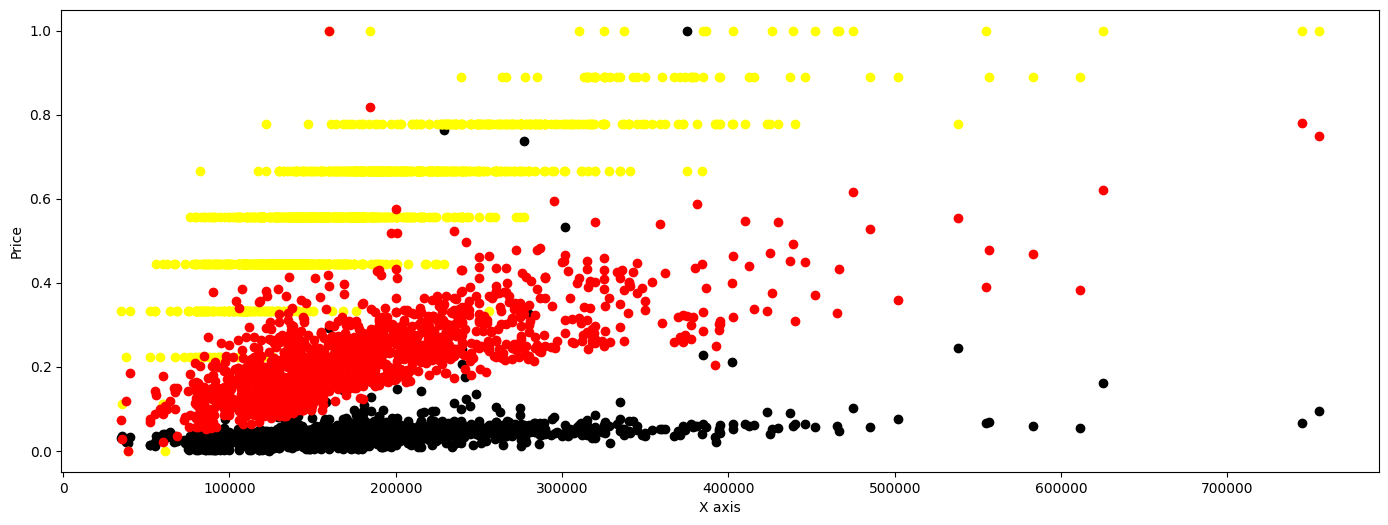

In [781]:
plt.figure(figsize=(17, 6))  
plt.scatter(train['SalePrice'],train_transformed['LotArea'],color='black')
plt.scatter(train['SalePrice'],train_transformed['OverallQual'],color='yellow')
plt.scatter(train['SalePrice'],train_transformed['GrLivArea'],color='red')
plt.xlabel('X axis')
plt.ylabel('Price')
plt.show()

## 2.2 Corelation Analysis

In [782]:
train_hihi = pd.concat([train_transformed, train.iloc[:,-1]], axis=1)
correlation_matrix = train_hihi.corr()

## 2.3 Feature extraction

In [783]:
last_column_correlations = correlation_matrix.iloc[:-1, -1]
most_correlated_features = last_column_correlations.abs().sort_values(ascending=False).index

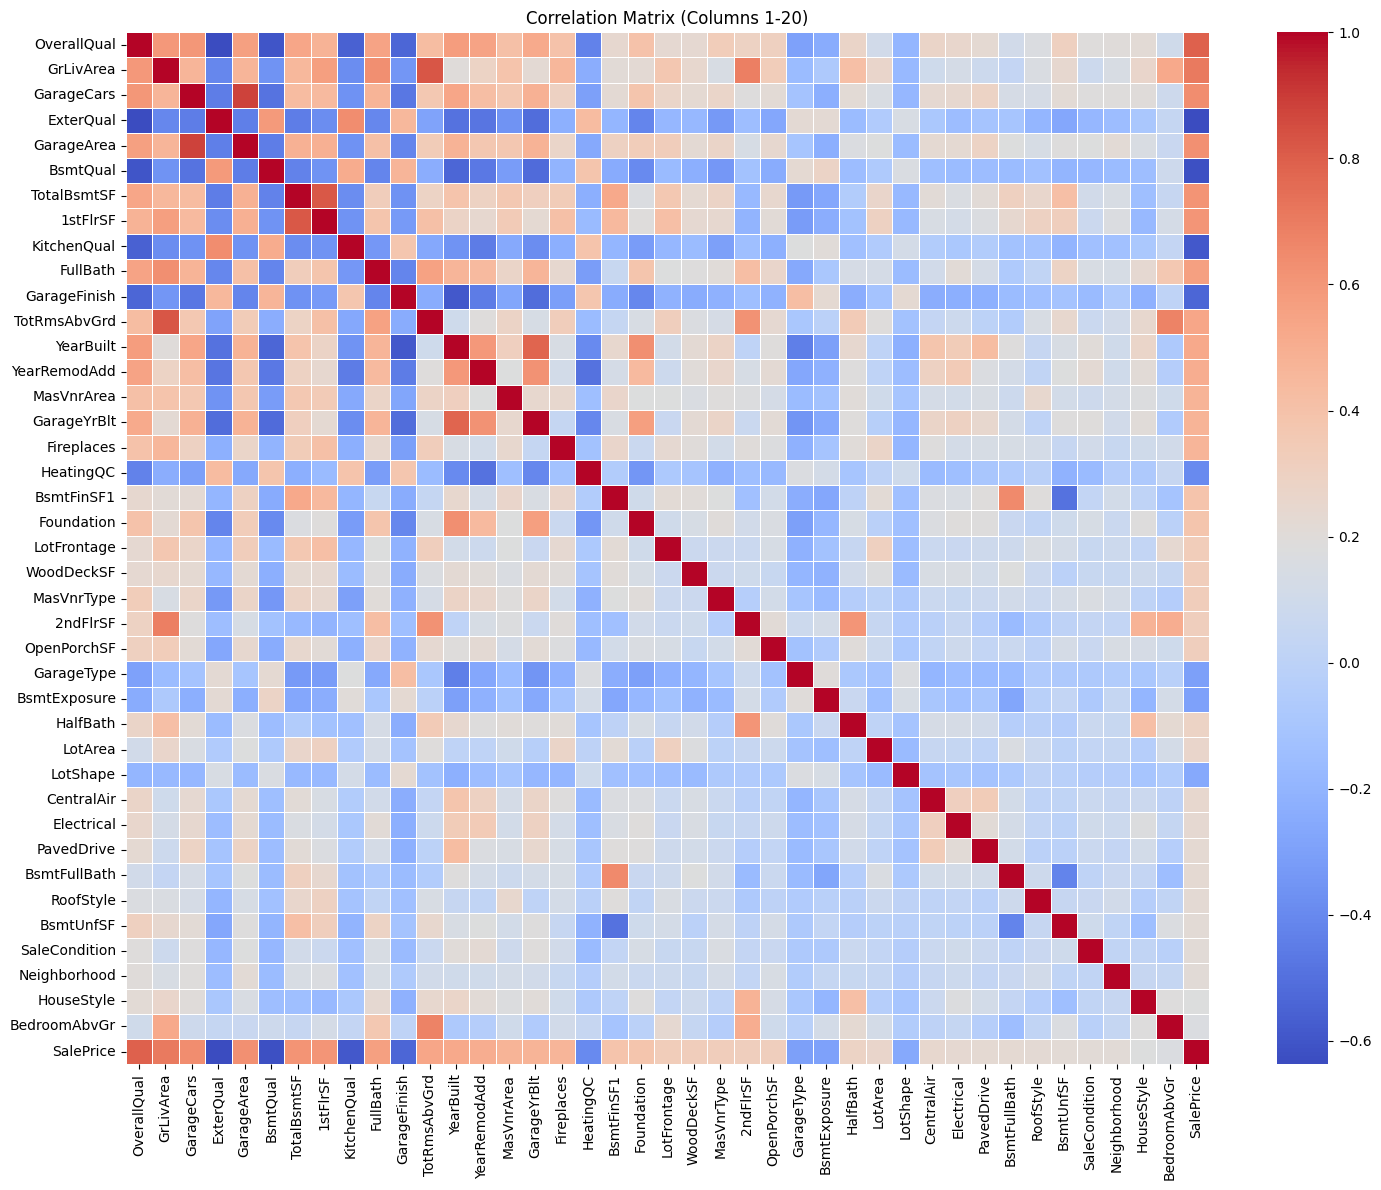

In [784]:
correlation_names = np.concatenate((most_correlated_features[:40],['SalePrice']))
plt.figure(figsize=(15, 12))

sns.heatmap(
    correlation_matrix.loc[correlation_names, correlation_names],
    annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5,
    xticklabels=correlation_names, yticklabels=correlation_names,
)
plt.title('Correlation Matrix (Columns 1-20)')
plt.tight_layout()
plt.show()


In [785]:
class TudisFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, features= None, features_no=1):
        self.features = features 
        self.features_no = features_no
       
    def fit(self, X,):
        return self
    
    def transform(self, X):
        
        X = pd.DataFrame(X,columns=features)
        correlated_features = self.features[:self.features_no]
        X = X.loc[:,correlated_features].to_numpy()
        return X

In [786]:
pip = Pipeline([
    ('preprocessor',preprocessor),
    ('extractor',TudisFeatureExtractor(features=most_correlated_features,features_no=79)),
], 
verbose=True
)

X_train = pip.transform(train)

## 3.2 Train Vadlidation Split

In [787]:
X_train, X_val, y_train, y_val = train_test_split(X_train, train['SalePrice'].values, test_size=0.1, shuffle=True,random_state=seed)
# y_train = train['SalePrice'].values

## 3.3 Feature importance

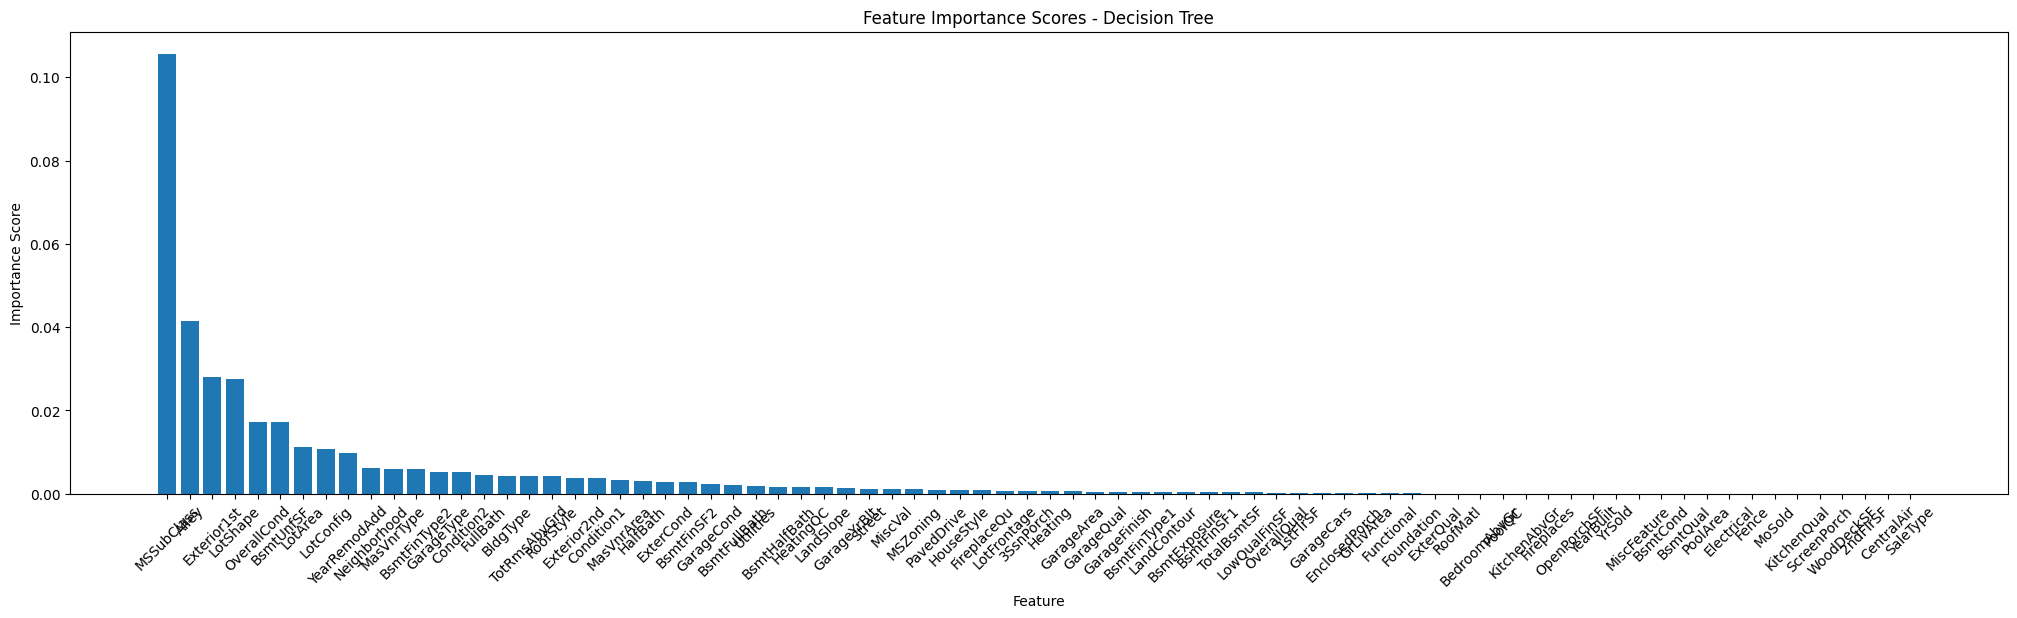

In [788]:
tree_model = DecisionTreeRegressor(random_state=seed)

tree_model.fit(X_train, y_train)
feature_importances = tree_model.feature_importances_

indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(25, 6))
plt.bar(range(X_train.shape[1]-1), feature_importances[indices[1:]], align="center")
plt.xticks(range(X_train.shape[1]-1), train.columns[indices[1:]], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance Scores - Decision Tree")
plt.show()

## 3. Model selection

In [789]:
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
models = {
    'XGB': XGBRegressor(random_state=seed),
    'GB': GradientBoostingRegressor(random_state=seed),
    # 'RF': RandomForestRegressor(random_state=seed),
    'LGB': LGBMRegressor(random_state=seed),
}


param_grids = {

    'XGB': {
        'max_depth': [3],
        'learning_rate': [0.06],
        'n_estimators': [270],
        'eval_metric': ['rmse'],
        'tree_method': ['exact'],
        'sampling_method':['uniform'],
        'subsample': [0.7],
        'colsample_bytree': [0.9],
        'reg_lambda': [0.2],
        
        
    },
    'GB': {
        'loss': ['huber'],
        'learning_rate': [0.07],
        'n_estimators' :[270],
        'max_depth':[3]
    },
    'LGB': {
        'num_leaves': [31],
        'learning_rate':[0.08],
        'n_estimators': [100],
        'objective': ['regression'],
        'force_col_wise': [True]
    }
}


## 4.1 Scoring method

In [790]:
def root_mean_squared_log_error(y_true, y_pred):
    log1p_true = np.log1p(y_true)
    log1p_pred = np.log1p(y_pred)
    
    squared_log_errors = (log1p_true - log1p_pred) ** 2
    mean_squared_log_error = np.mean(squared_log_errors)
    
    return np.sqrt(mean_squared_log_error)

In [791]:
best_models = {}
best_score = float('inf')
best_model = None 
custom_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

In [792]:
import contextlib

for model_name, model in models.items():
    param_grid = param_grids[model_name]

    with contextlib.redirect_stdout(None):
        grid_search = GridSearchCV(
            model,
            param_grid,
            cv=5,
            scoring=custom_scorer,
            verbose=False,
            return_train_score=True,
        )

        grid_search.fit(X_train, y_train)
        cv_results = grid_search.cv_results_

    best_models[model_name] = grid_search.best_estimator_

    # pretty-print model configurations
    print("=" * 170)
    for i, params in enumerate(cv_results['params']):
        score = abs(cv_results['mean_test_score'][i])
        print(f"[{model_name}]:\t{score}\t\t{params}\t")

[XGB]:	0.12683378081684582		{'colsample_bytree': 0.9, 'eval_metric': 'rmse', 'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 270, 'reg_lambda': 0.2, 'sampling_method': 'uniform', 'subsample': 0.7, 'tree_method': 'exact'}	
[GB]:	0.13146688896224998		{'learning_rate': 0.07, 'loss': 'huber', 'max_depth': 3, 'n_estimators': 270}	
[LGB]:	0.1333254552606032		{'force_col_wise': True, 'learning_rate': 0.08, 'n_estimators': 100, 'num_leaves': 31, 'objective': 'regression'}	


In [793]:
ensemble_clf = VotingRegressor(
    estimators=[
        ('GB',best_models['GB']),
        ('XGB',best_models['XGB']),
        ('LGB',best_models['LGB']),
    ],
    weights=[0.35, 0.34,0.31],
    verbose=True
)

param_grid_clf = {
    'weights': [
        [0.35, 0.35, 0.30], 
        [0.36, 0.34, 0.30], 
        [0.35, 0.36, 0.30], 
        [0.35, 0.34, 0.31], 
        [0.34, 0.34, 0.32], 
               ],
}

In [794]:
grid_search_ensemble = GridSearchCV(
    ensemble_clf,
    param_grid_clf,
    cv=5,
    scoring=custom_scorer,
    verbose=False,  
    n_jobs=-1,  
)

grid_search_ensemble.fit(X_train, y_train)
cv_results = grid_search_ensemble.cv_results_

print("=" * 170)
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"[{params}]:\t\t{abs(mean_score)}")

[Voting] ....................... (1 of 3) Processing GB, total=   2.9s
[Voting] ...................... (2 of 3) Processing XGB, total=   0.4s
[LightGBM] [Info] Total Bins 3282
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 73
[LightGBM] [Info] Start training from score 180704.734399
[Voting] ...................... (3 of 3) Processing LGB, total=   0.1s
[{'weights': [0.35, 0.35, 0.3]}]:		0.12620280669436412
[{'weights': [0.36, 0.34, 0.3]}]:		0.1264074362403981
[{'weights': [0.35, 0.36, 0.3]}]:		0.12652107757129255
[{'weights': [0.35, 0.34, 0.31]}]:		0.12617725572223057
[{'weights': [0.34, 0.34, 0.32]}]:		0.12629345706811587


In [795]:
ensemble_clf.fit(X_train,y_train)
y_pred = ensemble_clf.predict(X_val)
rMSE = root_mean_squared_log_error(y_val,y_pred)
print("[rMSE]:\t\t", rMSE)

[Voting] ....................... (1 of 3) Processing GB, total=   3.1s
[Voting] ...................... (2 of 3) Processing XGB, total=   0.3s
[LightGBM] [Info] Total Bins 3282
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 73
[LightGBM] [Info] Start training from score 180704.734399
[Voting] ...................... (3 of 3) Processing LGB, total=   0.2s
[rMSE]:		 0.11234316525657356


In [796]:
X_test = pip.transform(test)
test_preds = ensemble_clf.predict(X_test)

## 4. Metrics

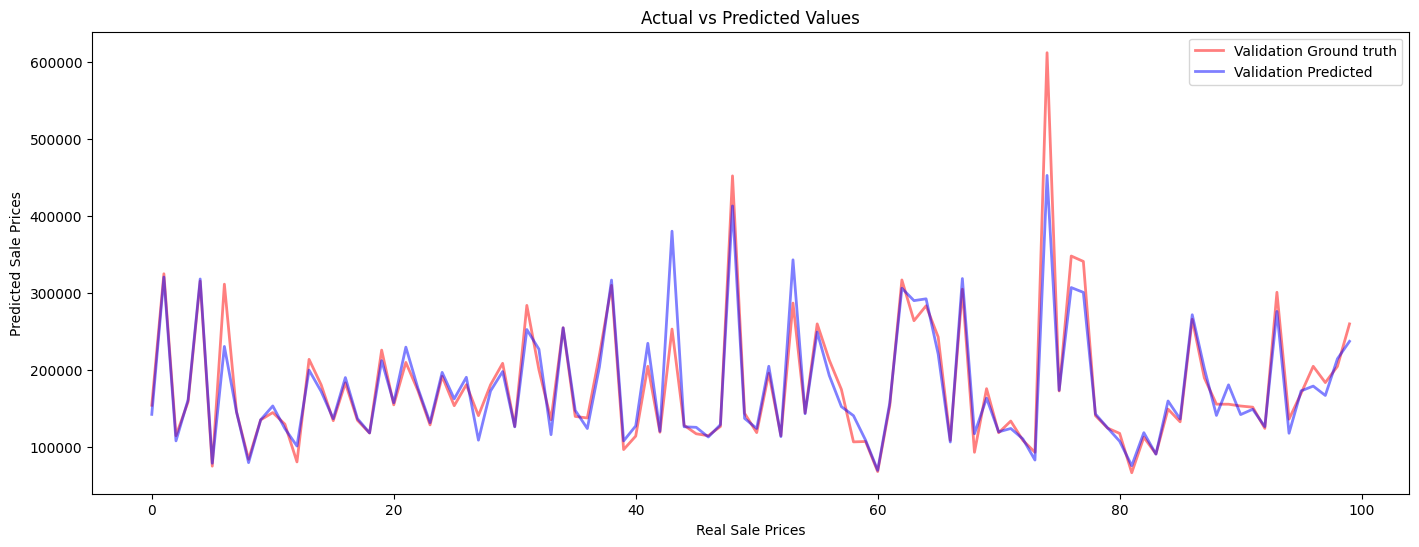

In [797]:
plt.figure(figsize=(17, 6))
plt.plot(y_val[:100], alpha=0.5, label='Validation Ground truth',color='red',linewidth=2)
plt.plot(y_pred[:100], alpha=0.5, label='Validation Predicted',color='blue',linewidth=2)
plt.xlabel('Real Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

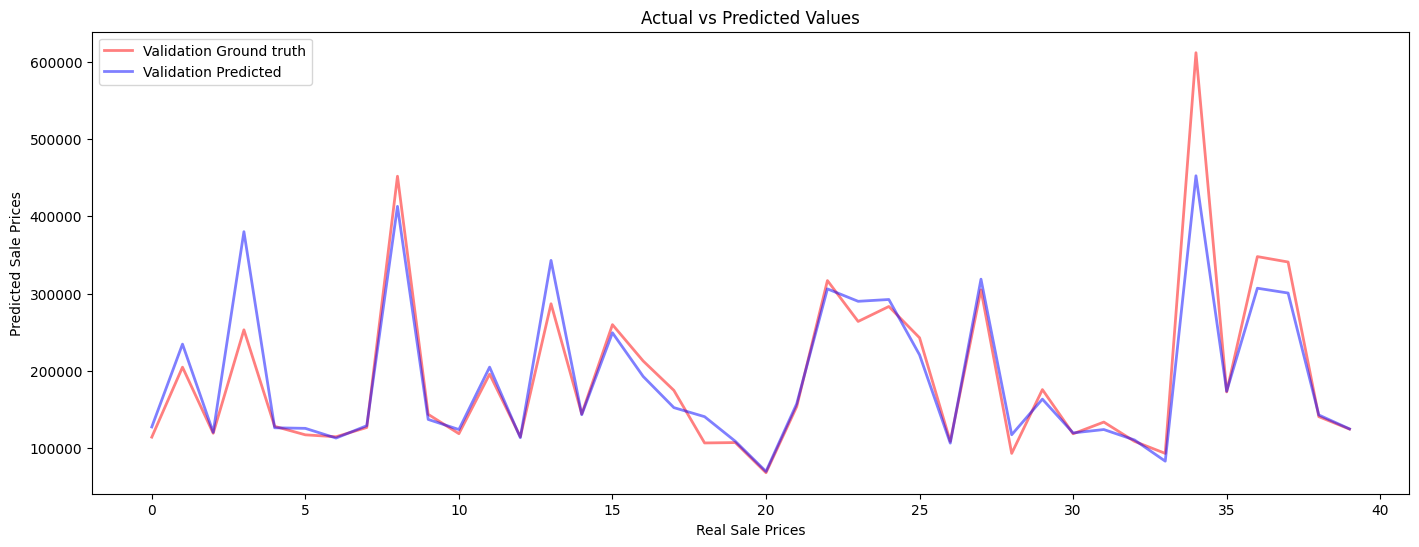

In [798]:
plt.figure(figsize=(17, 6))
plt.plot(y_val[40:80], alpha=0.5, label='Validation Ground truth',color='red',linewidth=2)
plt.plot(y_pred[40:80], alpha=0.5, label='Validation Predicted',color='blue',linewidth=2)
plt.xlabel('Real Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## KAGGLE

In [799]:
submission_data = np.column_stack((test.iloc[:,0],test_preds))
np.savetxt('kaggle.csv', submission_data, delimiter=',', header='Id,SalePrice', fmt='%d,%.4f', comments='')